In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

In [45]:
# Fungsi untuk mengonversi warna hex ke RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

# Membaca dataset dari CSV
data = pd.read_csv('color_combination.csv')

# List untuk menyimpan pasangan warna
top_colors = []
bottom_colors = []

# Memparsing dataset dan membuat pasangan warna
for index, row in data.iterrows():
    top_color = hex_to_rgb(row['top_color'])
    bottom_color_list = row['bottom_color'].split(', ')
    for bottom_color in bottom_color_list:
        top_colors.append(top_color)
        bottom_colors.append(hex_to_rgb(bottom_color))

# Konversi list ke array numpy
top_colors = np.array(top_colors)
bottom_colors = np.array(bottom_colors)

# Normalisasi warna
top_colors_normalized = top_colors / 255.0
bottom_colors_normalized = bottom_colors / 255.0

# Definisikan input dan palet warna
color_input = Input(shape=(3,), name='color')
palette_input = Input(shape=(5,3), name='palette')

palette_flatten = tf.keras.layers.Flatten()(palette_input)

# Concatenate warna input dengan palet warna
merged = Concatenate()([color_input, palette_flatten])

In [46]:
# Dense layers untuk mempelajari hubungan warna
dense = Dense(128, activation='relu')(merged)
dense = Dense(64, activation='relu')(dense)
output_color = Dense(3, activation='sigmoid')(dense)

# Membuat model
model = Model(inputs=[color_input, palette_input], outputs=output_color)
model.compile(optimizer='adam', loss='mse')

X_color = top_colors_normalized

num_top_colors = len(top_colors_normalized)
num_bottom_colors = len(bottom_colors) // 5

# Menyiapkan data untuk model
X_palette = bottom_colors_normalized.reshape(num_bottom_colors, 5, 3)
X_palette = np.tile(X_palette, (num_top_colors // num_bottom_colors, 1, 1))
y = bottom_colors_normalized  # Target adalah warna yang cocok

In [48]:
# Melatih model
model.fit([X_color, X_palette], y, epochs=1000, batch_size=8)

Epoch 1/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0471
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0499
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0522
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0468
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0458
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0449
Epoch 8/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0454
Epoch 9/1000
35/35 [==============================] - 0s 3ms/step - loss: 0.0425
Epoch 10/1000
35/35 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 11/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0424
Epoch 12/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0433
Epoch 13/1000
35/35 [====

In [49]:
# Simpan model jika diperlukan
model.save('color_matcher.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [60]:
# Memuat model yang sudah dilatih
model = tf.keras.models.load_model('color_matcher.h5')

# Definisikan fungsi untuk memprediksi warna yang cocok
def predict_matching_color(top_color_hex, palette_hex_list):
    top_color_rgb = hex_to_rgb(top_color_hex) / 255.0
    palette_rgb_list = np.array([hex_to_rgb(color) for color in palette_hex_list]) / 255.0

    # Memperluas dimensi untuk memasukkan ke dalam model
    top_color_input = np.expand_dims(top_color_rgb, axis=0)
    palette_input = np.expand_dims(palette_rgb_list, axis=0)

    # Melakukan prediksi
    predicted_color = model.predict([top_color_input, palette_input])

    # Mengubah hasil prediksi dari normalisasi ke format hex
    predicted_color_rgb = np.clip(predicted_color[0] * 255, 0, 255).astype(int)
    predicted_color_hex = '#{:02x}{:02x}{:02x}'.format(*predicted_color_rgb)

    return predicted_color_hex




In [65]:
# Contoh penggunaan fungsi prediksi
top_color_hex = "#f96210"
palette_hex_list = ['#746542', '#bbad33', '#8e302d', '#403786', '#957a4c']
predicted_color_hex = predict_matching_color(top_color_hex, palette_hex_list)

# print(f'Prediksi warna yang cocok untuk {top_color_hex} adalah: {predicted_color}')

1/1 [==============================] - 0s 26ms/step


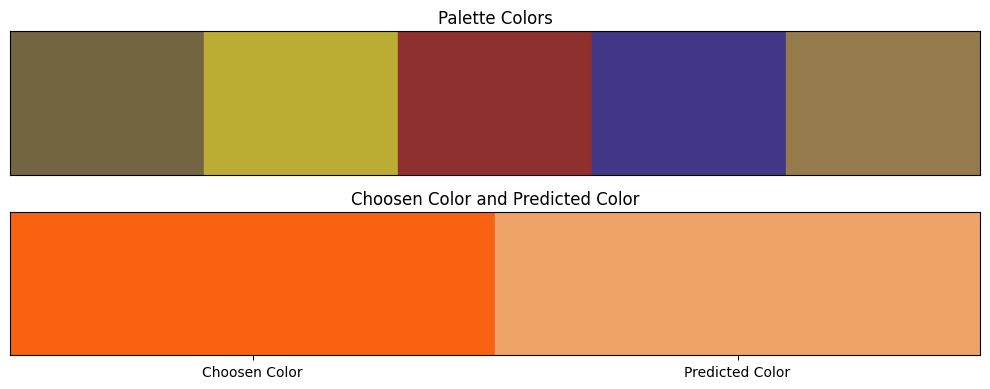

In [66]:
# Visualisasi menggunakan Matplotlib
import matplotlib.pyplot as plt

def plot_colors(top_color_hex, palette_hex_list, predicted_color_hex):
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))

    # Menampilkan palet warna
    for i, color_hex in enumerate(palette_hex_list):
        ax[0].add_patch(plt.Rectangle((i * 1.5, 0), 1.5, 1, color=color_hex))
    ax[0].set_xlim(0, 1.5 * len(palette_hex_list))
    ax[0].set_ylim(0, 1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Palette Colors')

    # Menampilkan top color dan predicted color berdampingan
    ax[1].add_patch(plt.Rectangle((0, 0), 1.5, 1, color=top_color_hex))
    ax[1].add_patch(plt.Rectangle((1.5, 0), 1.5, 1, color=predicted_color_hex))
    ax[1].set_xlim(0, 3)
    ax[1].set_ylim(0, 1)
    ax[1].set_xticks([0.75, 2.25])
    ax[1].set_xticklabels(['Choosen Color', 'Predicted Color'])
    ax[1].set_yticks([])
    ax[1].set_title('Choosen Color and Predicted Color')

    plt.tight_layout()
    plt.show()

plot_colors(top_color_hex, palette_hex_list, predicted_color_hex)